__ TOOLS FOR MANAGING THE ELECTION. NOT FOR REPORTING. __

2019!

In [182]:
#Plotting 
%matplotlib inline
from matplotlib import pyplot as plt
%config InlineBackend.figure_format = 'svg'
import seaborn as sns
sns.set(style="whitegrid")

#Base Classes stuff
from FileSystemTools import *
from UtilityDecorators import *
from UtilityFunctions import *

import pandas as pd
from pandas import DataFrame, Series
import numpy as np

BASE = getSystemRoot()
electionFolder = "%s/Desktop/ELECTION" % BASE
resultFile = "%s/Returns.xlsx" % electionFolder
electionReturnsFilePath = "%s/Election returns.xlsx" % electionFolder

# Load and process data

## Get results files

In [183]:
from FileSystemTools import makeDataFileList

In [5]:
results_files = [f for f in makeDataFileList(electionFolder) if f[-3:] == 'csv']
results_files

['/Users/adam/Desktop/ELECTION/New+Survey+%28030119%29_March+1%2C+2019_16.41.csv']

In [184]:
data = pd.read_csv(results_files[0])
data

,StartDate,EndDate,Status,Progress,Duration (in seconds),Finished,RecordedDate,ResponseId,DistributionChannel,UserLanguage,Q1,Q1_5_TEXT,Q1_6_TEXT,Q2
0,Start Date,End Date,Response Type,Progress,Duration (in seconds),Finished,Recorded Date,Response ID,Distribution Channel,User Language,Select 2 candidates from the following choices...,Select 2 candidates from the following choices...,Select 2 candidates from the following choices...,Choose which word best describes your mood today.
1,"{""ImportId"":""startDate"",""timeZone"":""America/De...","{""ImportId"":""endDate"",""timeZone"":""America/Denv...","{""ImportId"":""status""}","{""ImportId"":""progress""}","{""ImportId"":""duration""}","{""ImportId"":""finished""}","{""ImportId"":""recordedDate"",""timeZone"":""America...","{""ImportId"":""_recordId""}","{""ImportId"":""distributionChannel""}","{""ImportId"":""userLanguage""}","{""ImportId"":""QID4""}","{""ImportId"":""QID4_5_TEXT""}","{""ImportId"":""QID4_6_TEXT""}","{""ImportId"":""QID6""}"
2,3/1/19 11:52,3/1/19 11:52,IP Address,100,33,TRUE,3/1/19 11:52,R_2DOXKa9gpQ5iAjp,email,EN,"Idris Elba (Age 46),Dwayne Johnson (Age 46)",NaN,NaN,Fine (F.I.N.E.)
3,3/1/19 11:53,3/1/19 12:03,IP Address,100,593,TRUE,3/1/19 12:03,R_2QXOghCYpK04zLP,email,EN,"Blake Shelton (Age 42),David Beckham (Age 44)",NaN,NaN,Hopeful
4,3/1/19 12:11,3/1/19 12:11,IP Address,100,11,TRUE,3/1/19 12:11,R_3n34z6XpVbcyejz,email,EN,Idris Elba (Age 46),NaN,NaN,Sad
5,3/1/19 12:12,3/1/19 12:13,IP Address,100,25,TRUE,3/1/19 12:13,R_2nmHh2cvInviJUt,email,EN,"Blake Shelton (Age 42),Dwayne Johnson (Age 46)",NaN,NaN,Emotional
6,3/1/19 15:07,3/1/19 15:08,IP Address,100,20,TRUE,3/1/19 15:08,R_2wsHpXmO51DSvD6,email,EN,"Dwayne Johnson (Age 46),WRITE IN #1",Person who is most best,NaN,Fine (F.I.N.E.)
7,3/1/19 15:07,3/1/19 15:08,IP Address,100,20,TRUE,3/1/19 15:08,R_2wsHpXmO51DSvD6,email,EN,"WRITE IN #1, WRITE IN #2",Dwayne Johnson,Dwayne Johnson,Fine (F.I.N.E.)


## Remove non-response rows

In [185]:
dropped = data[data.index <= 1]
data = data[data.index > 1]

# Verify that no actual responses were dropped
dropped

,StartDate,EndDate,Status,Progress,Duration (in seconds),Finished,RecordedDate,ResponseId,DistributionChannel,UserLanguage,Q1,Q1_5_TEXT,Q1_6_TEXT,Q2
0,Start Date,End Date,Response Type,Progress,Duration (in seconds),Finished,Recorded Date,Response ID,Distribution Channel,User Language,Select 2 candidates from the following choices...,Select 2 candidates from the following choices...,Select 2 candidates from the following choices...,Choose which word best describes your mood today.
1,"{""ImportId"":""startDate"",""timeZone"":""America/De...","{""ImportId"":""endDate"",""timeZone"":""America/Denv...","{""ImportId"":""status""}","{""ImportId"":""progress""}","{""ImportId"":""duration""}","{""ImportId"":""finished""}","{""ImportId"":""recordedDate"",""timeZone"":""America...","{""ImportId"":""_recordId""}","{""ImportId"":""distributionChannel""}","{""ImportId"":""userLanguage""}","{""ImportId"":""QID4""}","{""ImportId"":""QID4_5_TEXT""}","{""ImportId"":""QID4_6_TEXT""}","{""ImportId"":""QID6""}"


## get results columns

In [186]:
def get_results_columns(frame):
    """Since we don't know how many questions there 
    will be, this returns all columns with the format
    Qx where x is an integer"""
    results_columns = []
    i = 1

    try:
        while True:
            c = 'Q{}'.format(i)
            if c in frame.columns:
                results_columns.append(c)
                i += 1
            else:
                raise StopIteration
    except StopIteration:
        return results_columns

def get_write_in_columns(frame, question_number):
    """Write in columns seem to have the format 
    'Q1_5_TEXT', 'Q1_6_TEXT'
    Thus this finds the relevant write in columns for a 
    given question
    """
    if type(question_number) is int:
        question_number = 'Q{}'.format(question_number)
    write_in_columns = []
    for col in frame.columns:
        s = col.split('_')
        # Write ins will have 3 items
        if len(s) > 1:
            if s[0] == question_number: #and s[-1] == 'TEXT':
                write_in_columns.append(col)
    return write_in_columns

    

In [187]:
 def make_test_frame(maxval=4):
    test_frame = { }
    expected = []
    for i in range(1, maxval + 1):
        e = []
        qnum = 'Q{}'.format(i)
        for j in range(1, maxval + 1):
            # add the main column
            test_frame[qnum] = [i,  qnum]
            c = 'Q{}_{}_TEXT'.format(i, j)
            # add the write in column
            test_frame[c] = [i,  qnum]
            e.append(c)
        expected.append((i, qnum, e))

    test_frame = DataFrame(test_frame)
    return {'test_frame': test_frame, 'expected': expected}


def test_get_write_in_columns(maxval = 4):
    r = make_test_frame(maxval)

    for exp in r['expected']:
        found_columns = get_write_in_columns(r['test_frame'], exp[0])
        for c in found_columns:
            try:
                assert(c in exp[2])
            except AssertionError:
                print(c, exp[2])
test_get_write_in_columns()

In [153]:
r = make_test_frame()
r['expected']

[(1, 'Q1', ['Q1_1_TEXT', 'Q1_2_TEXT', 'Q1_3_TEXT', 'Q1_4_TEXT']),
 (2, 'Q2', ['Q2_1_TEXT', 'Q2_2_TEXT', 'Q2_3_TEXT', 'Q2_4_TEXT']),
 (3, 'Q3', ['Q3_1_TEXT', 'Q3_2_TEXT', 'Q3_3_TEXT', 'Q3_4_TEXT']),
 (4, 'Q4', ['Q4_1_TEXT', 'Q4_2_TEXT', 'Q4_3_TEXT', 'Q4_4_TEXT'])]

In [154]:
get_write_in_columns(test_frame, 1)


['Q1_1_TEXT', 'Q1_2_TEXT', 'Q1_3_TEXT', 'Q1_4_TEXT']

In [124]:
test_frame

,Q1_1_TEXT,Q1_2_TEXT,Q1_3_TEXT,Q1_4_TEXT,Q2_1_TEXT,Q2_2_TEXT,Q2_3_TEXT,Q2_4_TEXT,Q3_1_TEXT,Q3_2_TEXT,Q3_3_TEXT,Q3_4_TEXT,Q4_1_TEXT,Q4_2_TEXT,Q4_3_TEXT,Q4_4_TEXT
0,1,1,1,1,2,2,2,2,3,3,3,3,4,4,4,4
1,Q1,Q1,Q1,Q1,Q2,Q2,Q2,Q2,Q3,Q3,Q3,Q3,Q4,Q4,Q4,Q4


In [112]:
expected

[(1, 'Q1', ['Q1_1_TEXT', 'Q1_2_TEXT', 'Q1_3_TEXT', 'Q1_4_TEXT']),
 (2, 'Q2', ['Q2_1_TEXT', 'Q2_2_TEXT', 'Q2_3_TEXT', 'Q2_4_TEXT']),
 (3, 'Q3', ['Q3_1_TEXT', 'Q3_2_TEXT', 'Q3_3_TEXT', 'Q3_4_TEXT']),
 (4, 'Q4', ['Q4_1_TEXT', 'Q4_2_TEXT', 'Q4_3_TEXT', 'Q4_4_TEXT'])]

In [10]:
data.columns

Index(['StartDate', 'EndDate', 'Status', 'Progress', 'Duration (in seconds)',
       'Finished', 'RecordedDate', 'ResponseId', 'DistributionChannel',
       'UserLanguage', 'Q1', 'Q1_5_TEXT', 'Q1_6_TEXT', 'Q2'],
      dtype='object')

In [188]:
# String processing of result cells

def find_dept(field):
    """Returns the string inside the first set of parentheses
    encountered, including the parentheses
    input "Idris Elba (Age 46),Dwayne Johnson (Age 48)"
    output '(Age 46)'
    """
    return field[field.find("(") : field.find(")") +1]

def remove_depts(field):
    """Removes all strings inside parentheses, including the
    parentheses. 
    This does not yet clean up whitespace or
    separate selections.
    input "Idris Elba (Age 46),Dwayne Johnson (Age 48)"
    output 'Idris Elba ,Dwayne Johnson (Age 48)'
    """
    try:
        while True:
            dept_string = find_dept(field)
            if not dept_string:
                raise StopIteration
            # re-join the list into a string for another pass
            field = ''.join(field.split(dept_string))
    except StopIteration:
        return field

test_field = "Idris Elba (Age 46),Dwayne Johnson (Age 48)"
expected = 'Idris Elba ,Dwayne Johnson '
assert(remove_depts(test_field) == expected)

In [189]:
test_cases =[
    (
        "Idris Elba (Age 46),Dwayne Johnson (Age 48)", 
        ['Idris Elba', 'Dwayne Johnson']
    ),
    (
        "Idris Elba (Family, science, and consumers ),Dwayne Johnson ( Geology)", 
        ['Idris Elba', 'Dwayne Johnson']
    ),
        (
        "Idris Elba (Family, science, and consumers ) ,Dwayne Johnson(Geology)", 
        ['Idris Elba', 'Dwayne Johnson']
    ),
    
        (
        "Idris Elba(Family, science, and consumers),Dwayne Johnson(Geology) ", 
        ['Idris Elba', 'Dwayne Johnson']
    )

]

In [190]:
def process_field(field, keep_depts=False):
    """Extracts all votes from a given cell"""
    if not keep_depts:
        field = remove_depts(field)
    votes = field.split(',')
    # clean up whitespace
    votes = [v.strip() for v in votes]
    return votes

# test
for raw, expected in test_cases:
    assert(process_field(raw) == expected)

In [191]:
def process_office(frame, column):
    """Returns a series with vote counts of all the selections
    NB, this does not handle write-ins"""
    votes = []
    for field in frame[column]:
        votes += process_field(field)
    # Make votes into a series and count it
    votes = pd.Series(votes, name='number_votes')
    return votes.value_counts()


In [203]:
def process_office_writeins(frame, writein_cols):
    """Returns a series with vote counts of written in candidates"""
#     writein_cols = get_write_in_columns(frame, question_number)
    votes = []
    for column in writein_cols:
        for field in frame[column]:
            print(field)
            if not pd.isnull(field):
                votes.append(field)
#             votes += process_field(field, keep_depts=True)
    # Make votes into a series and count it
    votes = pd.Series(votes, name='number_votes')
    return votes.value_counts()


In [211]:
def process_office_columns(frame, main_column, write_in_columns):
    """
    office_columns should be a list including the main office
    label (e.g., 'Q1') and any write-in fields
    """
    office_columns = main_column + write_in_columns
    votes = []
    for idx, row in frame[office_columns].iterrows():
        r = row.dropna()
#     for column in office_columns:
#         for field in frame[column]:

In [212]:
process_office_columns(data, ['Q1','Q1_5_TEXT', 'Q1_6_TEXT'])

Q1    Idris Elba (Age 46),Dwayne Johnson (Age 46)
Name: 2, dtype: object
Q1    Blake Shelton (Age 42),David Beckham (Age 44)
Name: 3, dtype: object
Q1    Idris Elba (Age 46)
Name: 4, dtype: object
Q1    Blake Shelton (Age 42),Dwayne Johnson (Age 46)
Name: 5, dtype: object
Q1           Dwayne Johnson (Age 46),WRITE IN #1
Q1_5_TEXT                Person who is most best
Name: 6, dtype: object
Q1           WRITE IN #1, WRITE IN #2
Q1_5_TEXT              Dwayne Johnson
Q1_6_TEXT              Dwayne Johnson
Name: 7, dtype: object


In [207]:
assert(',' in 'dog barkson')

AssertionError: 

In [179]:
wics = get_write_in_columns(data, 1)
wics

['Q1_5_TEXT', 'Q1_6_TEXT']

In [204]:
process_office_writeins(data, wics)

nan
nan
nan
nan
Person who is most best
Dwayne Johnson
nan
nan
nan
nan
nan
Dwayne Johnson


Dwayne Johnson             2
Person who is most best    1
Name: number_votes, dtype: int64

In [175]:
office_counts = []
for wic in wics:
    office_counts += process_office_writeins(data, wic)
office_counts

Series([], Name: number_votes, dtype: float64)

In [195]:
def process_results_frame(frame, output_file):
    results = []
    results_columns = get_results_columns(frame)
#     with pd.ExcelWriter(output_file) as writer:
    for c in results_columns:
        write_in_columns = get_write_in_columns(frame, c)
        office_counts = process_office(frame, c)
#             office_counts += process_office_writeins(frame, write_in_columns)

        print("writing results of {}".format(c))
        results.append((c, office_counts))
#         office_counts.to_excel(writer, sheet_name=c)
    return results

In [197]:
r = process_results_frame(data, resultFile)

writing results of Q1
writing results of Q2


In [198]:
r[0][1]

Dwayne Johnson    3
WRITE IN #1       2
Blake Shelton     2
Idris Elba        2
WRITE IN #2       1
David Beckham     1
Name: number_votes, dtype: int64

In [201]:
process_office_writeins(data, ['Q1_5_TEXT'])


nan


TypeError: 'float' object is not iterable

In [202]:
data['Q1_5_TEXT']

2                        NaN
3                        NaN
4                        NaN
5                        NaN
6    Person who is most best
7             Dwayne Johnson
Name: Q1_5_TEXT, dtype: object

In [ ]:
'Q1_1_TEXT'

# Problem cases

2 candidates with same name
    
    Same dept
    
    Different dept
    
Write in candidate with no dept

Write in candidate with dept in parentheses

Write in candidate with dept, no parentheses

Vote for 1 candidate, write in same candidate (up to num allowed -1)

Write same candidate in multiple times

# Questions

Do we need to check the 'Finished' field?

Do they have to vote on every office?

In [46]:
test_field = "Idris Elba (Age 46),Dwayne Johnson (Age 48)"

In [32]:
test_field[test_field.find("(") : test_field.find(")") +1]

'(Age 46)'

In [ ]:
s[s.find("(")+1:s.find(")")]

In [56]:
find_dept(test_field)

'(Age 46)'

In [53]:
remove_depts(test_field)

'Idris Elba ,Dwayne Johnson '

In [4]:
generalData = pd.read_excel(electionReturnsFilePath, sheet_name='Data-general')
generalData.set_index('Year', inplace=True)
generalEligible = generalData['Eligible']
generalData.drop(columns=['Final', 'Eligible', '%Eligible'], inplace=True)
generalData.dropna(axis=1, how='all', inplace=True)

senateData = pd.read_excel(electionReturnsFilePath, sheet_name='Data-senate')
senateData.set_index('Year', inplace=True)
senateEligible = senateData['Eligible']
senateData.drop(columns=['Final', 'Eligible', '%Eligible'], inplace=True)
senateData.dropna(axis=1, how='all', inplace=True)


def calc_proport_of_eligible(frame, year, total):
    numEligible = frame.loc[year]
    return total / numEligible

generalProport = generalData.apply(lambda x : calc_proport_of_eligible(generalEligible, x.index, x))
senateProport =  senateData.apply(lambda x : calc_proport_of_eligible(senateEligible, x.index, x))

# General election

## Total votes cast

In [ ]:
generalData

In [ ]:
fig, axes = plt.subplots(figsize=(8,4))
generalData.T.plot(ax=axes)
axes.set_title("General election -- total votes")
axes.set_ylabel("Total votes cast"); axes.set_xlabel("Day in election period")
fig.tight_layout()

## Proportion of eligible voters

In [ ]:
fig, axes = plt.subplots(figsize=(8,4))
generalProport.T.plot(ax=axes)
axes.set_title("General election returns -- proportion of eligible voters")
axes.set_ylabel("# eligible voters / total votes"); axes.set_xlabel("Day in election period")
fig.tight_layout()

## Daily marginal votes cast

In [ ]:
generalMarginal = generalData.T.sub(generalData.T.shift(1), axis='columns').T.drop('Day 1', axis=1)
generalMarginal

In [ ]:
fig, axes = plt.subplots(figsize=(8,4))
sns.boxplot(data=generalMarginal.dropna(axis=1), ax=axes)
axes.set_title("General election - marginal votes by day")
axes.set_ylabel("# votes (%s-%s)" % (generalMarginal.index.min(), generalMarginal.index.max()))
fig.tight_layout()

# Senate-elected positions election 

## Total votes cast

In [ ]:
senateData

In [ ]:
fig, axes = plt.subplots(figsize=(8,4))
senateData.T.plot(ax=axes)
axes.set_title("Senate-elected positions election --- total votes")
fig.tight_layout()

## Proportion of eligible voters

In [ ]:
fig, axes = plt.subplots(figsize=(8,4))
senateProport.T.plot(ax=axes)
axes.set_title("Senate election returns -- proportion of eligible senate voters")
axes.set_ylabel("# eligible voters / total votes"); axes.set_xlabel("Day in election period")
fig.tight_layout()

## Votes cast per day

In [ ]:
senateMarginal = senateData.T.sub(senateData.T.shift(1), axis='columns').T.drop('Day 1', axis=1)
senateMarginal

In [ ]:
fig, axes = plt.subplots(figsize=(8,4))
sns.boxplot(data=senateMarginal.dropna(axis=1), ax=axes)
axes.set_title("Senate-elected positions -- marginal votes by day")
axes.set_ylabel("# votes (%s-%s)" % (senateMarginal.index.min(), senateMarginal.index.max()))
fig.tight_layout()

# Election design and machinery

## Quick primer on elections 

Clarify categories of vote

Illegal: 
    - The ballot expresses a preference which cannot be satisfied within the bounds of the election.
    - The most common illegal ballots in this election involved: 
        - The voter selecting more than the allowed number of candidates; or, 
        - Xelecting the maximum number and then writing in an additional candidate.

Cast = abstentions + legal + illegal
- Cast plays no role except for auditing 

valid = legal + illegal
- These determine the denominator when a position requires a majority (i.e., > 50%)



In [23]:
ELECTION_YEAR = 2018
resultsFolder = "%s/Box Sync/Faculty Senate Collaborative Documents/Elections/Results/" % BASE
currentElection = "%s/%s Elections official results" % (resultsFolder, ELECTION_YEAR)
senateFolder = "%s/senate official results" % currentElection
generalFolder = "%s/general official results" % currentElection

In [71]:
resultFileString = "Results.xlsx"
senateFiles = [f for f in makeDataFileList(senateFolder) if f[-12:] == resultFileString]
generalFiles = [f for f in makeDataFileList(generalFolder) if f[-12:] == resultFileString]
senateFrames = [pd.read_excel(f) for f in senateFiles]
generalFrames = [pd.read_excel(f) for f in generalFiles]

In [75]:
def number_of_abstentions(frame):
    """Returns the number of blank ballots minus the
    number of write in votes"""
    # get the name of the first column. 
    # this will be the committee's name
    committeeName = frame.columns[0]
    abstentions = frame[frame[committeeName] == 'abstentions']['votes']
    abstentions = int(abstentions)
    # now we need to subtract the writeins
    # since any write-in will be  counted as an
    # abstention
    #
    # !!!!!!!!!!!!! todo double-check in code
    try:
        wi = frame[frame[committeeName] == 'writeins-unverified']['votes']
        wi = int(wi)        
        abstentions = abstentions + wi
    except:
        pass
    return (committeeName, abstentions)

def number_of_illegal_overselections(frame):
    # get the name of the first column. 
    # this will be the committee's name
    committeeName = frame.columns[0]
#     print(committeeName)
    v = frame[frame[committeeName] == 'illegal-overselection']['votes']
    v = int(v)
    return (committeeName, v)

def number_manually_disqualified(frame):
    committeeName = frame.columns[0]
#     print(committeeName)
    # get rid of any of the programmatically added columns
    v = frame.dropna()
    # add up the disqualified votes
    v = int(v.dq.sum())
    return (committeeName, v)

def number_illegal(frame):
    committeeName = frame.columns[0]
#     print(committeeName)
    #programmaticOverselections: too many boxes ticked
    po = number_of_illegal_overselections(frame)
    #write ins which invalidated the vote
    wi = number_manually_disqualified(frame)
    num =  po[1] + wi[1]
    return (committeeName, num)  

In [95]:
def get_frame_for_plotting(func, columnName):
    v =  [func(frame) for frame in senateFrames]
    v =  v + [func(frame) for frame in generalFrames]
    return DataFrame(v, columns=['election', columnName]).set_index('election')

def plot_frame(frame, title, ylabel):
    fig, axes = plt.subplots(figsize=(8,3))
    frame.plot(kind='bar', table=True, ax=axes)
    x_axis = axes.get_xaxis(); axes.set_ylabel(ylabel)
    x_axis.set_visible(False); axes.set_title(title)
    fig.tight_layout()

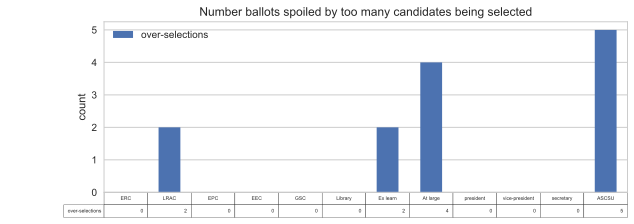

In [97]:
overselections = get_frame_for_plotting(number_of_illegal_overselections, 'over-selections')
plot_frame(overselections,  'Number ballots spoiled by too many candidates being selected', 'count')


## Write-in boxes


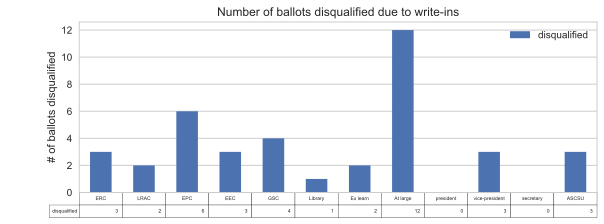

In [98]:
dq = get_frame_for_plotting(number_manually_disqualified, 'disqualified')
plot_frame(dq,"Number of ballots disqualified due to write-ins", "# of ballots disqualified")

### Abstentions 


### Abstentions 

Finally, it's worth looking briefly at rates of abstention. Those on the Senate know my militant view on abstentions. Holes are privations of dirt. Abstentions are privations of votes.^. 

This fits with the Robert's Rules treatment of abstentions, which governs our elections. [quote] only ballots which indicate a preference count toward vote totals. Obviously, we cannot infer from these rates that voters hated both candidates since it could've been that they loved them both equally^^ 



^ Technically, they exist but do not subsist

^^ For an argument that it isn't always rational to flip a coin in these cases, see Chang [ref]

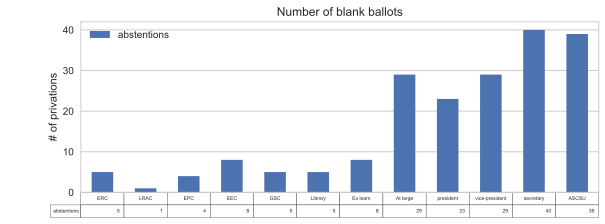

In [100]:
abstentions = get_frame_for_plotting(number_of_abstentions, 'abstentions')
plot_frame(abstentions, "Number of blank ballots", "# of privations")

# Questions:
- How many votes were invalid because of the overselection (illegal-overselction + invalid) in each election?

- How many abstentions were there

In [ ]:
SENATE_VOTES = 50 #todo refer to value calculated above, just need election year
SENATE_ELLIGIBLE = 71 #todo refer to value calculated above, just need election year

In [ ]:
# calculate illegal votes
illegalVotes = [number_illegal(frame) for frame in generalFrames]
# illegalVotes = DataFrame(illegalVotes, columns=['Office', 'Illegal votes'])
#abstentions

In [ ]:
generalAbstentions =  [number_of_abstentions(frame) for frame in generalFrames]
generalAbstentions = DataFrame(generalAbstentions, columns=['Position', 'Abstentions'])


In [ ]:
abstentions

In [ ]:
# calculate illegal votes
illegalVotes = [number_illegal(frame) for frame in senateFrames]
illegalVotes = DataFrame(illegalVotes, columns=['election', 'Illegal votes'])
# these are included in illegal
overselections = [number_of_illegal_overselections(frame) for frame in senateFrames]
overselections = DataFrame(overselections, columns=['election', 'Overselections'])

data = pd.merge(left=abstentions, right=illegalVotes, on='election').set_index('election')

In [ ]:
fig, axes = plt.subplots(figsize=(8,4))
data.plot(kind='bar', ax=axes)
axes.set_title("Counts of abstentions and illegal votes for standing committee elections")
axes.set_ylabel("Count")
fig.tight_layout()

In [ ]:
pctEligible = data.copy(deep=True)
pctVoters = data.copy(deep=True)
pctVoters.drop(['Abstentions', 'Illegal votes'], axis=1, inplace=True)
pctEligible.drop(['Abstentions', 'Illegal votes'], axis=1, inplace=True)


pctEligible['abstentions'] = data.Abstentions.apply(lambda x : x / SENATE_ELLIGIBLE)
pctEligible['illegal'] = data['Illegal votes'].apply(lambda x : x / SENATE_ELLIGIBLE)

pctVoters['abstentions'] = data.Abstentions.apply(lambda x : x / SENATE_VOTES)
pctVoters['illegal'] = data['Illegal votes'].apply(lambda x : x / SENATE_ELLIGIBLE)

# pctEligible['abstentions'] = data.Abstentions.apply(lambda x : int((x / SENATE_ELLIGIBLE)* 100))
# pctEligible['illegal'] = data['Illegal votes'].apply(lambda x : int((x / SENATE_ELLIGIBLE)* 100))

# pctVoters['abstentions'] = data.Abstentions.apply(lambda x : int((x / SENATE_VOTES) * 100))
# pctVoters['illegal'] = data['Illegal votes'].apply(lambda x : int((x / SENATE_ELLIGIBLE) * 100))

In [ ]:
fig, axes = plt.subplots(nrows=2)
pctEligible.plot(kind='bar', ax=axes[0])
axes[0].set_title("Abstentions and illegal votes as proportion of eligible voters")
axes[0].set_ylabel("count / # eligible ")
pctVoters.plot(kind='bar', ax=axes[1])
axes[1].set_ylabel("count / # case ")
axes[1].set_title("Abstentions and illegal votes as proportion of votes cast")
fig.tight_layout()

In [ ]:
a = get_number_of_abstentions(f)

In [ ]:
int(a[1])

In [ ]:
a

In [ ]:
b= "2018-03-23_11-47 ERC Results.xlsx"

In [ ]:
b[-12:]

# Election results computation

In [ ]:
#Generic system tools
import re, pprint, sys, json, os, shutil, webbrowser

import pandas as pd

#Base Classes stuff
# from FileSystemTools import *
# from UtilityDecorators import *
# from UtilityFunctions import *


%cd "/Users/adam/Dropbox/csun-election-management"
%run -i environment

# Load the data from the csv file into a dataframe
data = load_results_into_frame(INPUT_FOLDER_PATH)
# Give each row an id (also saves copy of the modified file for audits)
add_rowIds(data, FILE_W_ROW_IDS_PATH)

%cd "/Users/adam/Dropbox/csun-election-management/counter/src/"
from DataObjects import * 
%cd "/Users/adam/Dropbox/csun-election-management/Input/Election-definitions"

import csv

def read_csv_mapping(csvFile, firstColIsKey=True):
    """Returns a dictionary mapping values in the first column to values in the second. That way
     the second column list of tuples for each row of the stored item

    Args:
        firstColIsKey (oboolean): Whether the first column in the file is to be used as keys
    """
    with open(csvFile) as csvFile:
        reader = csv.reader(csvFile, quotechar='|')
        out = {}
        for row in reader:
            if firstColIsKey:
                out[row[0]] =  row[1]
            else:
                out[row[1]] = row[0]
        return out


read_csv_mapping('Office2.csv')

import pandas as pd

data


make_election_obj_from_file('Office2.xlsx')

d = pd.read_excel('Office2.xlsx')
d.columns

fieldNames = ['953897: Choose 2 (ONLY 2) of the following:', '955923: Choose 4 (ONLY 4) of the following:']

%cd "/Users/adam/Dropbox/csun-election-management"
%run -i click_to_tabulate_votes

# considering removing dependency on pandas
import csv
def read_csv(csvFile):
    """Returns a list of tuples for each row of the stored item"""
    with open(csvFile) as csvFile:
        reader = csv.reader(csvFile, quotechar='|')
        out = []
        for row in reader:
            out.append(tuple(row))
        return out

fileList = makeDataFileList(INPUT_FOLDER_PATH)
d = read_csv(fileList[0])
d

#extract valid names for test use
names = []
for n in fieldNames:
    ns = []
    for r in data[n]:
        ns += ResultFieldProcessor.process_field_values(r)
    ns = list(set(ns))
    names.append(ns)
        
print (names)
    

# create elections
election1 = OfficeElection('office1', '953897: Choose 2 (ONLY 2) of the following:', names[0], 2 )
election2 = OfficeElection('office1', '955923: Choose 4 (ONLY 4) of the following:', names[1], 4 )

vc1 = VoteCounter(election1)
vc1.count(data)

vc2 = VoteCounter(election2)
vc2.count(data)

# Give each row a unique identifier


# Save the file with a new, timestamped identifier


# Strip out any identifying data


# Save again with new id

# Load list of relevant columns

# Create candidate count dict

# Separate each field into a list

# Validate names (we don't want a wierd string to throw things off )

# If more than 4 valid names, store in log and throw exception

# If 0-4 valid names, add to the count


from pandas import Series, DataFrame


vc2.getResults()

v = Series(vc2.resultsDict)

v.plot(kind='bar')

# Developing test data

In [ ]:
        testNames = ['smith, john (bio)', 'sanchez, jill (chem)']
        maxValid = 2
        election = DO.OfficeElection('office1', 'field name', testNames, maxValid)
        vc = P.VoteCounter(election)
        testFrame = DataFrame([{ testNames[0] : testNames[0]}])
        # call


In [ ]:
from faker import Faker
fake = Faker()

def make_candidate():
    dept = "%s %s %s" % (fake.word(), fake.word(), fake.word())
    return "%s, %s (%s)" % (fake.last_name(), fake.first_name(), dept)



In [ ]:
NUMBER_VOTERS = 3
NUMBER_CANDIDATES = 3
NUMBER_INVALID = 0

FIELD_NAME = fake.bs()

In [ ]:
d = {'j':8}
setattr(d, 'j', 9)
d

In [ ]:
def make_vote_string(candidates):
    """Creates the record we are expecting to find in the canvas export"""
    if type(candidates) is str: 
        candidates = [ candidates ]
    r = ""
    for c in candidates:
        r = "%s,%s" % (r, c)
    # slice before return to remove an initial comma
    return r[1:]

make_vote_string('')

In [ ]:
b = [1, 2]
b + b

In [ ]:
candidates = [make_candidate() for i in range(0, NUMBER_CANDIDATES )]

In [ ]:
# All valid; 1 vote for each candidate
DataFrame([ { FIELD_NAME : c } for c in candidates])

In [ ]:
# All vote for all candidates
f = []
for i in range(0, NUMBER_VOTERS):
    r = ""
    for c in candidates:
        r = "%s,%s" % (r, c)
    f.append({ FIELD_NAME : r[1:] }) # there will be an initial comma otherwise
DataFrame(f)

In [ ]:
# 1 abstains

In [ ]:
candidates

In [ ]:
import faker

In [ ]:
a = faker.Factory()

In [ ]:
a.create()

In [ ]:
j = DataFrame([{'a' : 1, 'b':4}, {'a' : 5, 'b':46}])


In [ ]:
j.sort_values(by='a', ascending=False)

In [ ]:
j.drop(['a'], axis=1)

In [ ]:
k = 'a b c '
k = k.strip()
k

In [ ]:



d = pd.read_csv("%s/Senate Election - Spring 2018 Survey Student Analysis Report.csv" % electionFolder)

In [ ]:
for idx, row in d.iterrows():
    print(pd.isna(row[7]), row[7])